In [48]:
# =============================
# 1. Imports and Setup
# =============================
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
from tifffile import imread
from tqdm import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from scipy.spatial.distance import cdist


In [2]:
# =============================
# 2. Load DINOv2 Model (ViT-S/14)
# =============================
print("Loading DINOv2 model (ViT-S/14)...")
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
model.eval()
model = model.cpu()  # switch to .cuda() if GPU is available

Loading DINOv2 model (ViT-S/14)...


Using cache found in /home/amtissot/.cache/torch/hub/facebookresearch_dinov2_main
/home/amtissot/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/amtissot/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/amtissot/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [3]:
# =============================
# 3. Define Image Transform
# =============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet stats
        std=[0.229, 0.224, 0.225]
    )
])


In [4]:
# =============================
# 4. Feature Extraction Function
# =============================
def extract_dino_feature(image_path, model):
    img = imread(image_path)

    if img.ndim == 2:  # Convert grayscale to RGB
        img = np.stack([img] * 3, axis=-1)

    pil_img = Image.fromarray(img.astype(np.uint8))
    tensor = transform(pil_img).unsqueeze(0).cpu()

    with torch.no_grad():
        output = model(tensor)

    return output.squeeze().cpu().numpy()

In [5]:
# =============================
# 5. Extract Features for All Images
# =============================
crop_dir = "/home/amtissot/Desktop/LIMNC/hologram_dataset_ML_project/campaigns/training_data_NN_dated/rois_crops"
output_csv = "dinov2_features.csv"

features_list = []
filenames = []

print("Extracting features from image crops...")
for fname in tqdm(sorted(os.listdir(crop_dir))):
    if fname.endswith(".tiff"):
        fpath = os.path.join(crop_dir, fname)
        try:
            feat = extract_dino_feature(fpath, model)
            features_list.append(feat)
            filenames.append(fname)
        except Exception as e:
            print(f"Error processing {fname}: {e}")

Extracting features from image crops...


100%|██████████| 4794/4794 [02:09<00:00, 37.08it/s]


In [56]:
# =============================
# 6. Save Feature Matrix
# =============================
df = pd.DataFrame(features_list)
df["filename"] = filenames
df.to_csv(output_csv, index=False)
print(f"Saved features for {len(df)} images to {output_csv} (shape: {df.shape})")

Saved features for 4794 images to dinov2_features.csv (shape: (4794, 385))


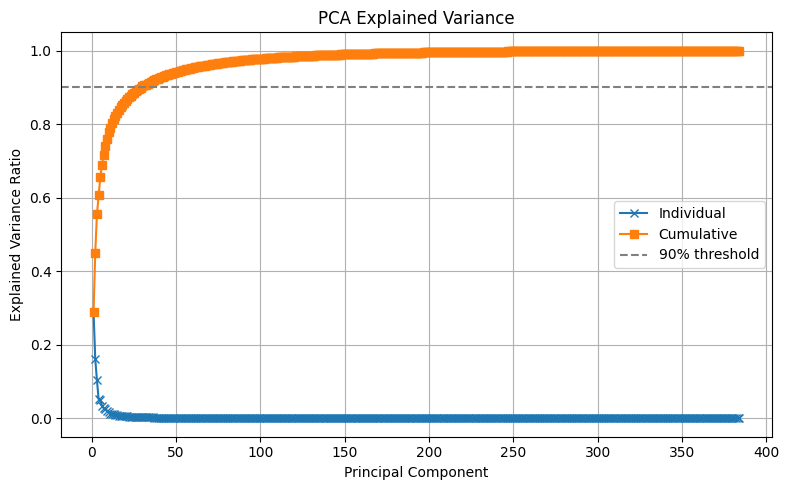

Number of components for 90% variance: 30


In [60]:
# =============================
# 7. PCA Analysis and Dimensionality Reduction
# =============================
# Reload and normalize
df = pd.read_csv(output_csv)
X = df.drop(columns=["filename"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA decomposition
pca_var = PCA()
X_pca_full = pca_var.fit_transform(X_scaled)

explained_variance = pca_var.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='x', label='Individual')
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='s', label='Cumulative')
plt.axhline(0.9, color='gray', linestyle='--', label='90% threshold')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Number of components for 90% variance
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components for 90% variance: {n_components_90}")

In [63]:
# =============================
# 8. Merge with Labels (Optional)
# =============================
csv_labels = "/home/amtissot/Desktop/LIMNC/hologram_dataset_ML_project/campaigns/training_data_NN_dated/rois_labels_nn.csv"
df_meta = pd.read_csv(csv_labels)

df_merged = df.merge(df_meta[["filename", "label"]], on="filename", how="left")
print(f"Merged feature-label dataset shape: {df_merged.shape}")

X = df_merged.drop(columns=["filename", "label"])
y = df_merged["label"].values
filenames = df_merged["filename"]

# Normalize again (in case of missing data)
X_scaled = scaler.fit_transform(X)


Merged feature-label dataset shape: (4794, 386)


/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


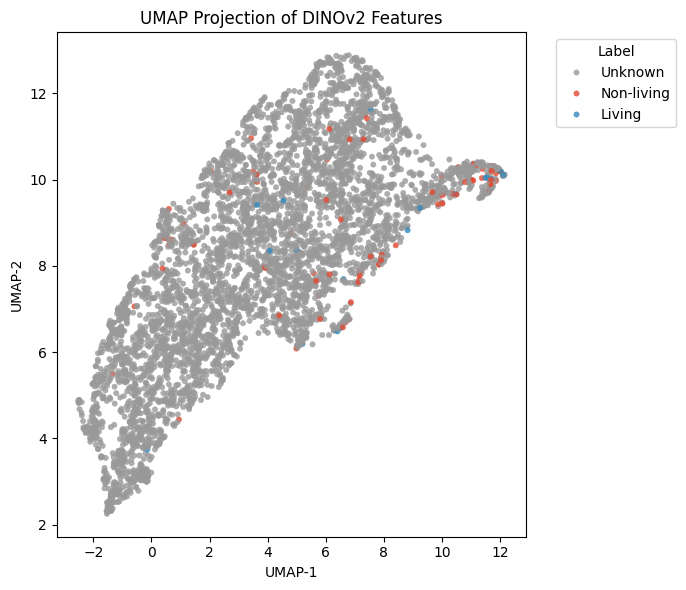

In [69]:
# =============================
# 9. UMAP Visualization of DINO Features
# =============================

# Reduce with PCA before UMAP
X_pca_30 = PCA(n_components=30).fit_transform(X_scaled)
X_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(X_pca_30)

# Define consistent color palette
palette = {
    'Unknown': '#999999',       # Grey
    'Non-living': '#E24A33',    # Strong Red
    'Living': '#348ABD'         # Strong Blue
}

# Plot
plt.figure(figsize=(7, 6))
sns.scatterplot(
    x=X_umap[:, 0], y=X_umap[:, 1],
    hue=y, palette=palette, alpha=0.8, s=15, edgecolor=None  # s controls point size
)
plt.title("UMAP Projection of DINOv2 Features")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True)
plt.tight_layout()
plt.savefig("/home/amtissot/Desktop/LIMNC/figures/umap_dinov2_features.png", dpi=300)
plt.show()


In [35]:
# =============================
# 10. Filter and Encode Labels
# =============================

# Keep only Living and Non-living
df_binary = df_merged[df_merged['label'].isin(['Living', 'Non-living'])].copy()
df_binary['label_binary'] = (df_binary['label'] == 'Living').astype(int)  # Living = 1, Non-living = 0

X = df_binary.drop(columns=['filename', 'label', 'label_binary'])
y = df_binary['label_binary'].values

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA reduction before classification
pca_30 = PCA(n_components=30)
X_pca_30 = pca_30.fit_transform(X_scaled)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_pca_30, y, test_size=0.4, stratify=y, random_state=42)

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

In [37]:
# =============================
# 11. Train Random Forest classifiers
# =============================
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf_rf.fit(X_train, y_train)

clf_rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf_smote.fit(X_train_smote, y_train_smote)

clf_rf_under = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf_under.fit(X_train_under, y_train_under)

RandomForestClassifier(random_state=42)

In [38]:
# =============================
# 12. Evaluate Random Forest Classifier
# =============================
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf_smote = clf_rf_smote.predict(X_test)
y_pred_rf_under = clf_rf_under.predict(X_test)

print("Random Forest")
print(classification_report(y_test, y_pred_rf))

print("Random Forest with SMOTE")
print(classification_report(y_test, y_pred_rf_smote))

print("Random Forest with Undersampling")
print(classification_report(y_test, y_pred_rf_under))

Random Forest
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        35
           1       0.00      0.00      0.00         9

    accuracy                           0.80        44
   macro avg       0.40      0.50      0.44        44
weighted avg       0.63      0.80      0.70        44

Random Forest with SMOTE
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        35
           1       0.40      0.22      0.29         9

    accuracy                           0.77        44
   macro avg       0.61      0.57      0.58        44
weighted avg       0.73      0.77      0.75        44

Random Forest with Undersampling
              precision    recall  f1-score   support

           0       0.77      0.66      0.71        35
           1       0.14      0.22      0.17         9

    accuracy                           0.57        44
   macro avg       0.45      0.44      0.44        44
we

/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [39]:
# =============================
# 13. Train and Evaluate XGB classifiers
# =============================

clf_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
clf_xgb.fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_test)

print("\nXGBoost")
print(classification_report(y_test, y_pred_xgb))

# With SMOTE
clf_xgb_smote = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
clf_xgb_smote.fit(X_train_smote, y_train_smote)
y_pred_xgb_smote = clf_xgb_smote.predict(X_test)

print("\nXGBoost with SMOTE")
print(classification_report(y_test, y_pred_xgb_smote))

# Undersampling
clf_xgb_under = XGBClassifier(n_estimators=100, random_state=42)
clf_xgb_under.fit(X_train_under, y_train_under)
y_pred_rf_under = clf_xgb_under.predict(X_test)

print("\nRandom Forest with Undersampling")
print(classification_report(y_test, y_pred_rf_under))


XGBoost
              precision    recall  f1-score   support

           0       0.79      0.86      0.82        35
           1       0.17      0.11      0.13         9

    accuracy                           0.70        44
   macro avg       0.48      0.48      0.48        44
weighted avg       0.66      0.70      0.68        44


XGBoost with SMOTE
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        35
           1       0.22      0.22      0.22         9

    accuracy                           0.68        44
   macro avg       0.51      0.51      0.51        44
weighted avg       0.68      0.68      0.68        44


Random Forest with Undersampling
              precision    recall  f1-score   support

           0       0.74      0.57      0.65        35
           1       0.12      0.22      0.15         9

    accuracy                           0.50        44
   macro avg       0.43      0.40      0.40        44
weighted av

/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:09:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:09:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [40]:
# =============================
# 14. Train LGBM classifiers
# =============================

clf_lgbm = LGBMClassifier(random_state=42, n_estimators=100)
clf_lgbm.fit(X_train, y_train)
y_pred_lgbm = clf_lgbm.predict(X_test)

print("\nLightGBM")
print(classification_report(y_test, y_pred_lgbm))

clf_lgbm_smote = LGBMClassifier(random_state=42, n_estimators=100)
clf_lgbm_smote.fit(X_train_smote, y_train_smote)
y_pred_lgbm_smote = clf_lgbm_smote.predict(X_test)

print("\nLightGBM with SMOTE")
print(classification_report(y_test, y_pred_lgbm_smote))

clf_lgbm_under = LGBMClassifier(random_state=42, n_estimators=100)
clf_lgbm_under.fit(X_train_under, y_train_under)
y_pred_lgbm_under = clf_lgbm_under.predict(X_test)

print("\nLightGBM with Undersampling")
print(classification_report(y_test, y_pred_lgbm_under))

[LightGBM] [Info] Number of positive: 14, number of negative: 51
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 65, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215385 -> initscore=-1.292768
[LightGBM] [Info] Start training from score -1.292768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

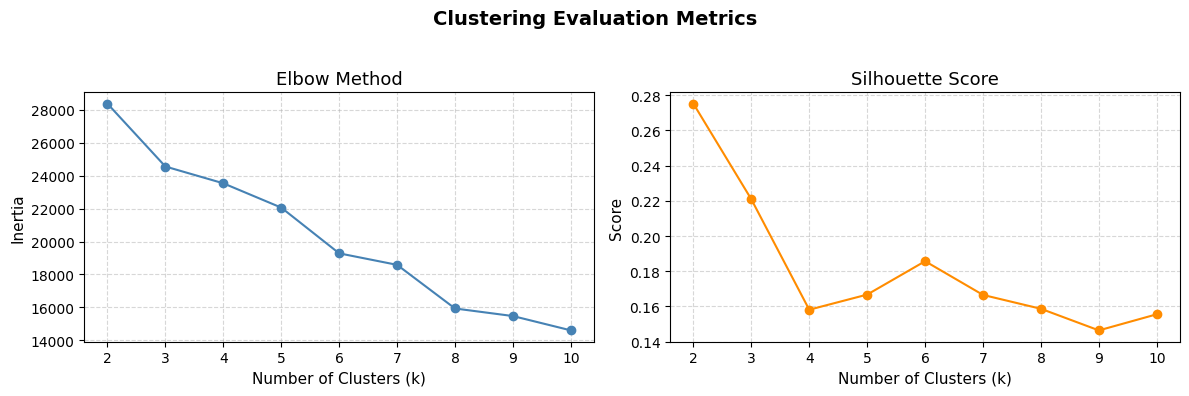

In [51]:
# =============================
# 15. Optional: Clustering with Elbow and Silhouette
# =============================
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def plot_elbow_silhouette(X, max_k=10):
    inertia = []
    sil_scores = []

    k_range = range(2, max_k + 1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        inertia.append(kmeans.inertia_)
        sil_scores.append(silhouette_score(X, labels))

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Elbow Plot
    axs[0].plot(k_range, inertia, marker='o', color='steelblue')
    axs[0].set_title("Elbow Method", fontsize=13)
    axs[0].set_xlabel("Number of Clusters (k)", fontsize=11)
    axs[0].set_ylabel("Inertia", fontsize=11)
    axs[0].grid(True, linestyle='--', alpha=0.5)

    # Silhouette Score Plot
    axs[1].plot(k_range, sil_scores, marker='o', color='darkorange')
    axs[1].set_title("Silhouette Score", fontsize=13)
    axs[1].set_xlabel("Number of Clusters (k)", fontsize=11)
    axs[1].set_ylabel("Score", fontsize=11)
    axs[1].grid(True, linestyle='--', alpha=0.5)

    plt.suptitle("Clustering Evaluation Metrics", fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("/home/amtissot/Desktop/LIMNC/figures/silhouette_elbow_DINO.png", dpi=300, bbox_inches='tight')
    plt.show()

# Run clustering analysis if desired
plot_elbow_silhouette(X_pca_30)


/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


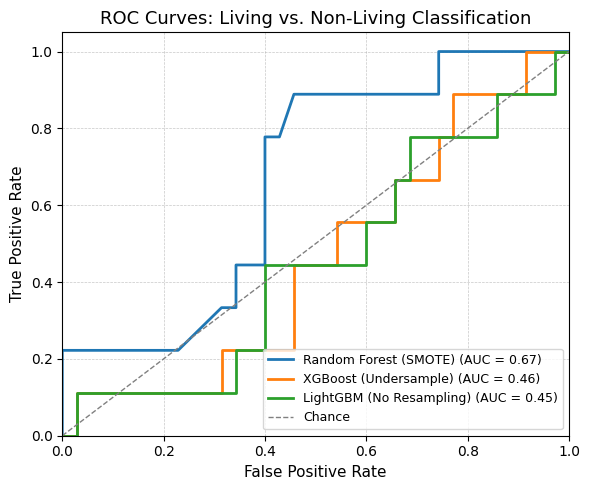

In [50]:
# =============================
# 16. ROC AUC Curves for Classification
# =============================

def plot_roc_curve(clf, X_test, y_test, label="Model"):
    """
    Plot ROC curve for a binary classifier.

    Parameters:
    - clf: trained classifier with .predict_proba()
    - X_test: test features
    - y_test: true labels
    - label: label for the curve in the plot
    """
    y_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
    return fpr, tpr, roc_auc
plt.figure(figsize=(6, 5))

# Curves
plot_roc_curve(clf_rf_smote, X_test, y_test, label="Random Forest (SMOTE)")
plot_roc_curve(clf_xgb_under, X_test, y_test, label="XGBoost (Undersample)")
plot_roc_curve(clf_lgbm, X_test, y_test, label="LightGBM (No Resampling)")

# Chance line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')

# Axes labels and limits
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC Curves: Living vs. Non-Living Classification', fontsize=13)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Legend
plt.legend(loc='lower right', fontsize=9, frameon=True)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("/home/amtissot/Desktop/LIMNC/figures/ROC_DINO.png", dpi=300, bbox_inches="tight")
plt.show()


In [49]:
# =============================
# 17. Intra- and Inter-Class Distances
# =============================

def compute_inter_intra_class_dists(X, y):
    X_0 = X[y == 0]
    X_1 = X[y == 1]

    intra_0 = np.mean(cdist(X_0, X_0))
    intra_1 = np.mean(cdist(X_1, X_1))
    inter = np.mean(cdist(X_0, X_1))

    print(f"Intra-class distance (Non-Living): {intra_0:.2f}")
    print(f"Intra-class distance (Living):     {intra_1:.2f}")
    print(f"Inter-class distance:              {inter:.2f}")
    
compute_inter_intra_class_dists(X_pca_30, y)

Intra-class distance (Non-Living): 23.76
Intra-class distance (Living):     28.78
Inter-class distance:              27.43
